In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util

In [2]:
# Output directories

proj_dir = os.path.join(pc_consts['official_indir'], 'TARGET')

figure_outdir = 'figures'
output_dir = 'outputs'
outfile_dir = os.path.join(output_dir, 'outfiles')
outdir = proj_dir

os.makedirs(figure_outdir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(outfile_dir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

In [3]:
path_dict = {}
path_dict['tumor'] = os.path.join(proj_dir, 'cohort1.methyl.tsv')
# path_dict['normal'] = os.path.join(pc_consts['official_indir'], 'Normals', f'beta_values-{normals_TCGA_name}.tsv')

data = local_util.getDataDict(path_dict, filter_tum_samps=False, assert_same_sites=False)
data['tumor']['beta_values'] = data['tumor']['beta_values'].dropna(axis=1, how='all')
data['tumor']['pureSamples'] = data['tumor']['pureSamples'][np.isin(data['tumor']['pureSamples'], data['tumor']['beta_values'].columns)]

In [4]:
outfile_path = os.path.join(proj_dir, 'beta_values_unbiased_sites.txt')

criteria = local_util.CLOCK_CRITERIA.copy()

# NO NORMAL SAMPLE
if 'normal' not in data['cohorts']:
    del criteria['normal']

unbiased_sites = local_util.gen_CpG_set(data, criteria=criteria, neutral_DNA_CpG_list=None)
data['tumor']['beta_values_SELECTION'].loc[unbiased_sites].to_csv(outfile_path, sep='\t')

Selecting CpGs with:
	213 TCGA samples


# Purity QC

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


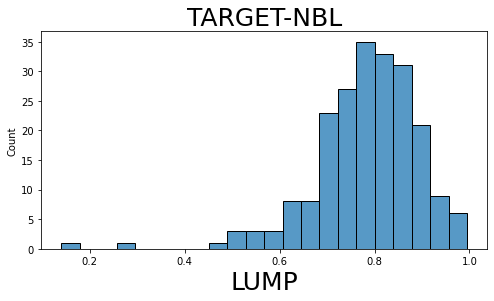

In [5]:
# Examine LUMP values - will not filter for now
LUMP_values = pc_util.getLUMP_values(data['tumor']['beta_values'])
sf = 1

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(LUMP_values)

ax.set_xlabel('LUMP', fontsize=pc_consts['labelfontsize']*sf)
ax.set_title('TARGET-NBL', fontsize=pc_consts['labelfontsize']*sf)

LUMP_values.to_csv(os.path.join(proj_dir, 'LUMP_purity.txt'), sep='\t')